## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question requires you to write a short description of a Computer Vision method. You wil lneed to submit two separate files, one for each question.

# Question 1: A simple classifier, 20 marks (70%)

For this exercise, we provide demo code showing how to train a network on a small dataset called Fashion-MNIST. Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

Q1.1 (1 point)

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

Q1.2 (2 point) Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1    |20.0%|
|0.1  |42.9%|
|0.01 |59.9%|
|0.001|61.8%|


Q1.3 (3 point) Report the number of epochs when the network converges (or nukber of epochs for the best accuracy, if it fails to converge). Fill in the table below and plot the loss curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


Q1.4 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


Q1.5 (5 points) Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |      ||
|Deeper|          ||
|Wider|         ||


Q1.6 (2 points) Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

Q1.7 (5 points) Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [36]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [38]:
batch_size = 64
num_workers = 20

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

Size and shape of training images: torch.Size([1, 28, 28])


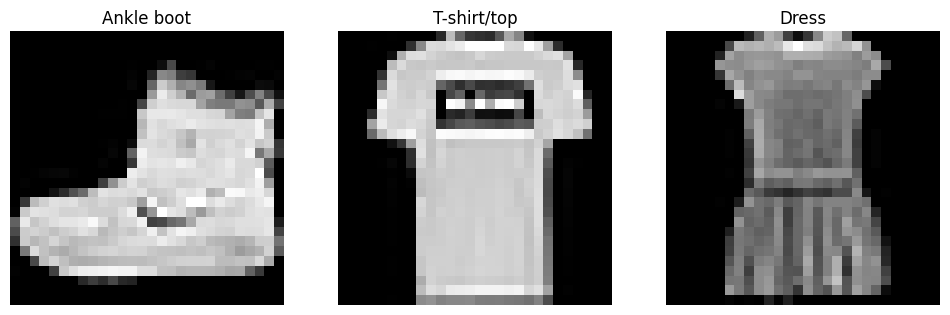

In [8]:
print(f"Size and shape of training images: {training_data[0][0].shape}")

# defining the function to draw the images
def plot_image(image, label, ax):
    image = image.numpy().squeeze()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{training_data.classes[label]}')
    ax.axis('off')


images, labels = [], []
unique_labels = set()
for img, lbl in training_data:
    if lbl not in unique_labels:
        images.append(img)
        labels.append(lbl)
        unique_labels.add(lbl)
    if len(unique_labels) >= 3:
        break


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for img, lbl, ax in zip(images, labels, axes):
    plot_image(img, lbl, ax)
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [41]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [42]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.592934  [    0/60000]
loss: 0.767794  [ 6400/60000]
loss: 0.437623  [12800/60000]
loss: 0.733908  [19200/60000]
loss: 0.864606  [25600/60000]
loss: 0.615355  [32000/60000]
loss: 0.771728  [38400/60000]
loss: 0.882595  [44800/60000]
loss: 0.773922  [51200/60000]
loss: 0.787544  [57600/60000]
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.664063 

Epoch 2
-------------------------------
loss: 0.594110  [    0/60000]
loss: 0.755079  [ 6400/60000]
loss: 0.439827  [12800/60000]
loss: 0.723811  [19200/60000]
loss: 0.878717  [25600/60000]
loss: 0.572997  [32000/60000]
loss: 0.754157  [38400/60000]
loss: 0.855430  [44800/60000]
loss: 0.743428  [51200/60000]
loss: 0.736492  [57600/60000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.645678 

Epoch 3
-------------------------------
loss: 0.579866  [    0/60000]
loss: 0.741095  [ 6400/60000]
loss: 0.432610  [12800/60000]
loss: 0.716788  [19200/60000]
loss: 0.830729  [25600/60000]
loss: 0.544369  [32000/600

In [44]:
# Reseting the functions and small modifications for the next couple of questions


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)

def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [43]:
# Question 1.2

learnRate = [1, 0.1, 0.01, 0.001]

for learnR in learnRate:
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learnR)
    epochs = 10
    lossArr = []
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        loss, correct = test(test_dataloader, model, loss_fn)

        lossArr.append(loss)

    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), lossArr, marker='o', linestyle='-', color='b')
    plt.title(f"loss graph for learnRate: {learnR}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
        
print("Done!")

loss: 2.308044  [    0/60000]
loss: 2.061347  [ 6400/60000]
loss: 2.316760  [12800/60000]
loss: 3.225693  [19200/60000]
loss: 1.529039  [25600/60000]
loss: 1.780399  [32000/60000]
loss: 3.028064  [38400/60000]
loss: 1.728857  [44800/60000]
loss: 1.757735  [51200/60000]
loss: 1.686988  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.732433 



TypeError: cannot unpack non-iterable NoneType object

In [45]:
learnRate = [1, 0.1, 0.01, 0.001]
results = []

for learnR in learnRate:
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learnR)
    epochs = 10
    lossArr = []
    best_accuracy = 0
    best_epoch = 0

    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        loss, accuracy = test(test_dataloader, model, loss_fn)

        print(loss)

        lossArr.append(loss)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = t + 1

    results.append((learnR, best_accuracy, best_epoch))

    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), lossArr, marker='o', linestyle='-', color='b')
    plt.title(f"Loss graph for learning rate: {learnR}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


nan
nan
nan


KeyboardInterrupt: 

Using cpu device
WiderNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Number of trainable parameters in wider model: 1863690
DeeperNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)
Number of trainable parameters in deeper model: 1195018
Epoch 1/10, Loss: 0.2722
Epoch 2/10, Loss: 0.1280
Epoch 3/10, L

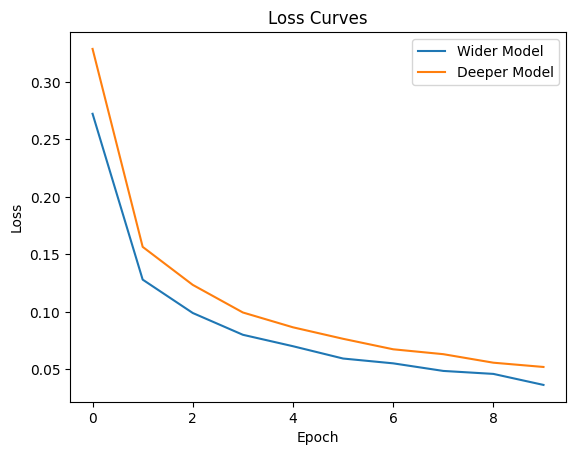

In [34]:
import torch.optim as optim

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define wider model
class WiderNeuralNetwork(nn.Module):
    def __init__(self):
        super(WiderNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

wider_model = WiderNeuralNetwork().to(device)
print(wider_model)

# Number of parameters in wider model
wider_model_params = sum(p.numel() for p in wider_model.parameters())
print(f'Number of trainable parameters in wider model: {wider_model_params}')

# Define deeper model
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

deeper_model = DeeperNeuralNetwork().to(device)
print(deeper_model)

# Number of parameters in deeper model
deeper_model_params = sum(p.numel() for p in deeper_model.parameters())
print(f'Number of trainable parameters in deeper model: {deeper_model_params}')

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10
num_workers = 20

# Load data
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Training function
def train(model, optimizer, criterion, epochs):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    return loss_values

# Evaluation function
def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# Train and evaluate wider model
wider_optimizer = optim.Adam(wider_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
wider_loss_values = train(wider_model, wider_optimizer, criterion, epochs)
wider_accuracy = evaluate(wider_model)
print(f'Wider Model Accuracy: {wider_accuracy:.4f}')

# Train and evaluate deeper model
deeper_optimizer = optim.Adam(deeper_model.parameters(), lr=learning_rate)
deeper_loss_values = train(deeper_model, deeper_optimizer, criterion, epochs)
deeper_accuracy = evaluate(deeper_model)
print(f'Deeper Model Accuracy: {deeper_accuracy:.4f}')

# Plot loss curves
plt.figure()
plt.plot(wider_loss_values, label='Wider Model')
plt.plot(deeper_loss_values, label='Deeper Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Question 2: Proposal for Practical Applications (30%)

In this part of the assignment you need to write a report about an application of a computer vision algorithnm or technique. This can either be an application that you are aware of and possibly even use, such as a phone app, or it could be speculation -- an application that you think would benefit from using computer vision. 

Begin by choosing a particular CV idea, method or problem area, such as:

a. removing noise in an image

b. increasing the resolution of an image

c. detecting and/or identifying objects in an image

d. segmenting images into constituents parts

e. estimating the depth of an object from one or more images

f. estimating the motion of two objects in different frames

g. others

Now think about various ways your chosen technique could be used. Here is a list of possible applications you could consider, but you are not restricted to this list, and there will be credit given for sensible invention outside this list (but no penalty if you don't want to be "inventive"): image editing systems in your phone; enhancement of images from old film; obstacle detection and avoidance for a domestic robot; facial recognition for phone security; cancer detection; person tracking and re-identification in security cameras; sport decision review systems; road-sign detection and interpretation for self-driving cars.

This is a little bit back-to-front from what might happen in real life in which the application usually motivates the solution, but the emphasis here is on an understanding of the CV technique.

You need to write a short report (800 words max) in which you do the following:
1. Clearly define the CV problem/area and describe its application scenarios
2. Briefly describe a solution based on image processing, computer vision and/or machine learning.
3. Discuss the advantages and the limitations of this method in various application scenarios

Hint1: Submit an individual pdf report for question 2.

Hint2: Organise your report well

Hint3: You can use diagrams, flow charts or other figures in your report for better understanding of your solution.  

***You do not need to implement your solution; just write the proposal/report and submit it as a separate PDF***


